# Let's search for the real gravitational wave

We will consider the first detected GW described as GW150914.

For this we will use publicly available data from the portal: `www.gw-openscience.org`:

https://www.gw-openscience.org/catalog/GWTC-1-confident/single/GW150914/

There you can find the data from two interferometers: LIGO Livingston and Hanford. You can either take data sampled with frequency of 4 kHz or 16 kHz.

Since we need to whiten the data (as in previous tutorial) we need couple hundreds second.

According to the website, the GW event started on 1126259462.4 GPS time.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from matplotlib.colors import LogNorm

In [2]:
data_file = "H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5"

In [3]:
h5 = h5py.File(data_file, "r")

The HDF5 file contains all the information you need to analyse the chosen dataset like strain or some metaparameters.

In [4]:
# Depending on the Python type, you might have to convert the output to the list
list(h5.keys())

['meta', 'quality', 'strain']

In [5]:
strain = np.array(h5["strain"]["Strain"])

We need the gps start time of this data segment.

In [6]:
list(h5["meta"].keys())

['Description',
 'DescriptionURL',
 'Detector',
 'Duration',
 'GPSstart',
 'Observatory',
 'Type',
 'UTCstart']

In [7]:
gps_start = h5["meta"]["GPSstart"].value

In [8]:
h5.close()

In [9]:
gps_end = gps_start + 4096

In [10]:
# In GPS time
gps_start, gps_end

(1126257415, 1126261511)

In [11]:
fs = 4096

In [12]:
# Let's create gps time vector
gps_time = np.linspace(gps_start, gps_end, 4096*fs)

In [13]:
gps_start_event = 1126259462.4

In [14]:
# Let's search for the starting index of the GW event
gw_event_start_id = np.where(np.round(gps_time) == round(gps_start_event))[0][0]

In [15]:
# In the hours
gps_start/3600, gps_end/3600, gps_start_event/3600

(312849.28194444446, 312850.4197222222, 312849.8506666667)

In [68]:
# Let's take two seconds of the data to show the GW
strain_gw = strain[gw_event_start_id:(gw_event_start_id+int(1.5*fs))]
time_gw = gps_time[gw_event_start_id:(gw_event_start_id+int(1.5*fs))]

Text(0.5, 1.0, 'GW150914 - raw strain')

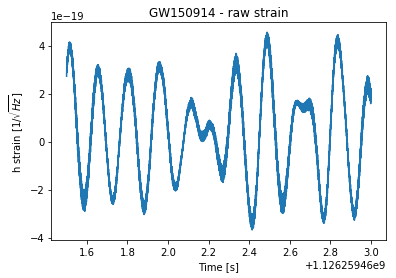

In [69]:
plt.plot(time_gw, strain_gw)
plt.xlabel("Time [s]")
plt.ylabel(r'h strain [1/$\sqrt{Hz}$]')
plt.title("GW150914 - raw strain")

In [31]:
# Let's now take the noise to create the model whitening the data; 300 seconds of noise should be enough
strain_noise = strain[1200*fs:1500*fs]
time_noise = gps_time[1200*fs:1500*fs]

In [38]:
# Now, the whitening GLSAR model
model = sm.GLSAR(strain_noise, time_noise, rho=3000)

In [39]:
# Time for train our model!
for i in range(20):
    results = model.fit()
    rho, sigma = sm.regression.yule_walker(results.resid, order=model.order)
    model = sm.GLSAR(strain_noise, time_noise, rho)

In [70]:
# After the training; we can finally whiten our strain data
whitened_strain = model.whiten(strain_gw)

Text(0.5, 1.0, 'GW150914 - whitened strain')

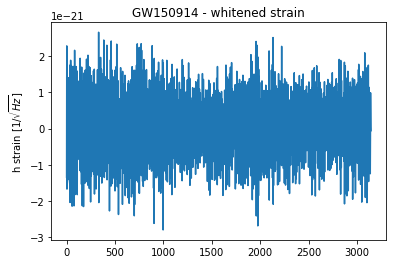

In [71]:
plt.plot(whitened_strain)
#plt.xlabel("Time [s]")
plt.ylabel(r'h strain [1/$\sqrt{Hz}$]')
plt.title("GW150914 - whitened strain")

# At the end - let's create spectrogram

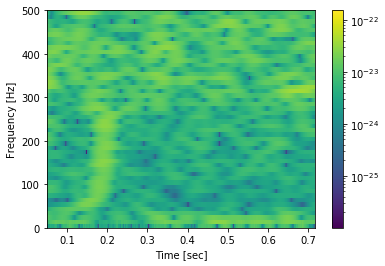

In [72]:
k, f_samp = 10, 4096
glitch=whitened_strain

plt.figure()
fp, tp, Sxxp = signal.spectrogram(glitch, window='hann',fs=fs, noverlap=99*fs//(k*100), nperseg=fs//k, nfft=fs//k)
log_sq_Sxxp = np.log(np.sqrt(Sxxp))
plt.pcolormesh(tp, fp, log_sq_Sxxp, cmap='viridis')
plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
v1, v2 = np.sqrt(Sxxp.min()), np.sqrt(Sxxp.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.ylim([0,500])
#plt.xlim([0.0, 0.3])
plt.pcolormesh(tp, fp, log_sq_Sxxp, norm=Log10scale, cmap='viridis')
plt.colorbar() 

# The quality of the whitening will depend on the quality of the strain in the given interval. Since we are using raw interferometric data, there are glitches buried there as well as GW signal. If you take the strain segment containing something else than just the usual noise, your whitening model might not correctly clean the data.